# Project 2: Least-Squares Classification

## Step 1: Download and load the MNIST datasets

Download the training and test datasets. Use the provided function to load the first 5000 images and labels of the training dataset

In [1]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

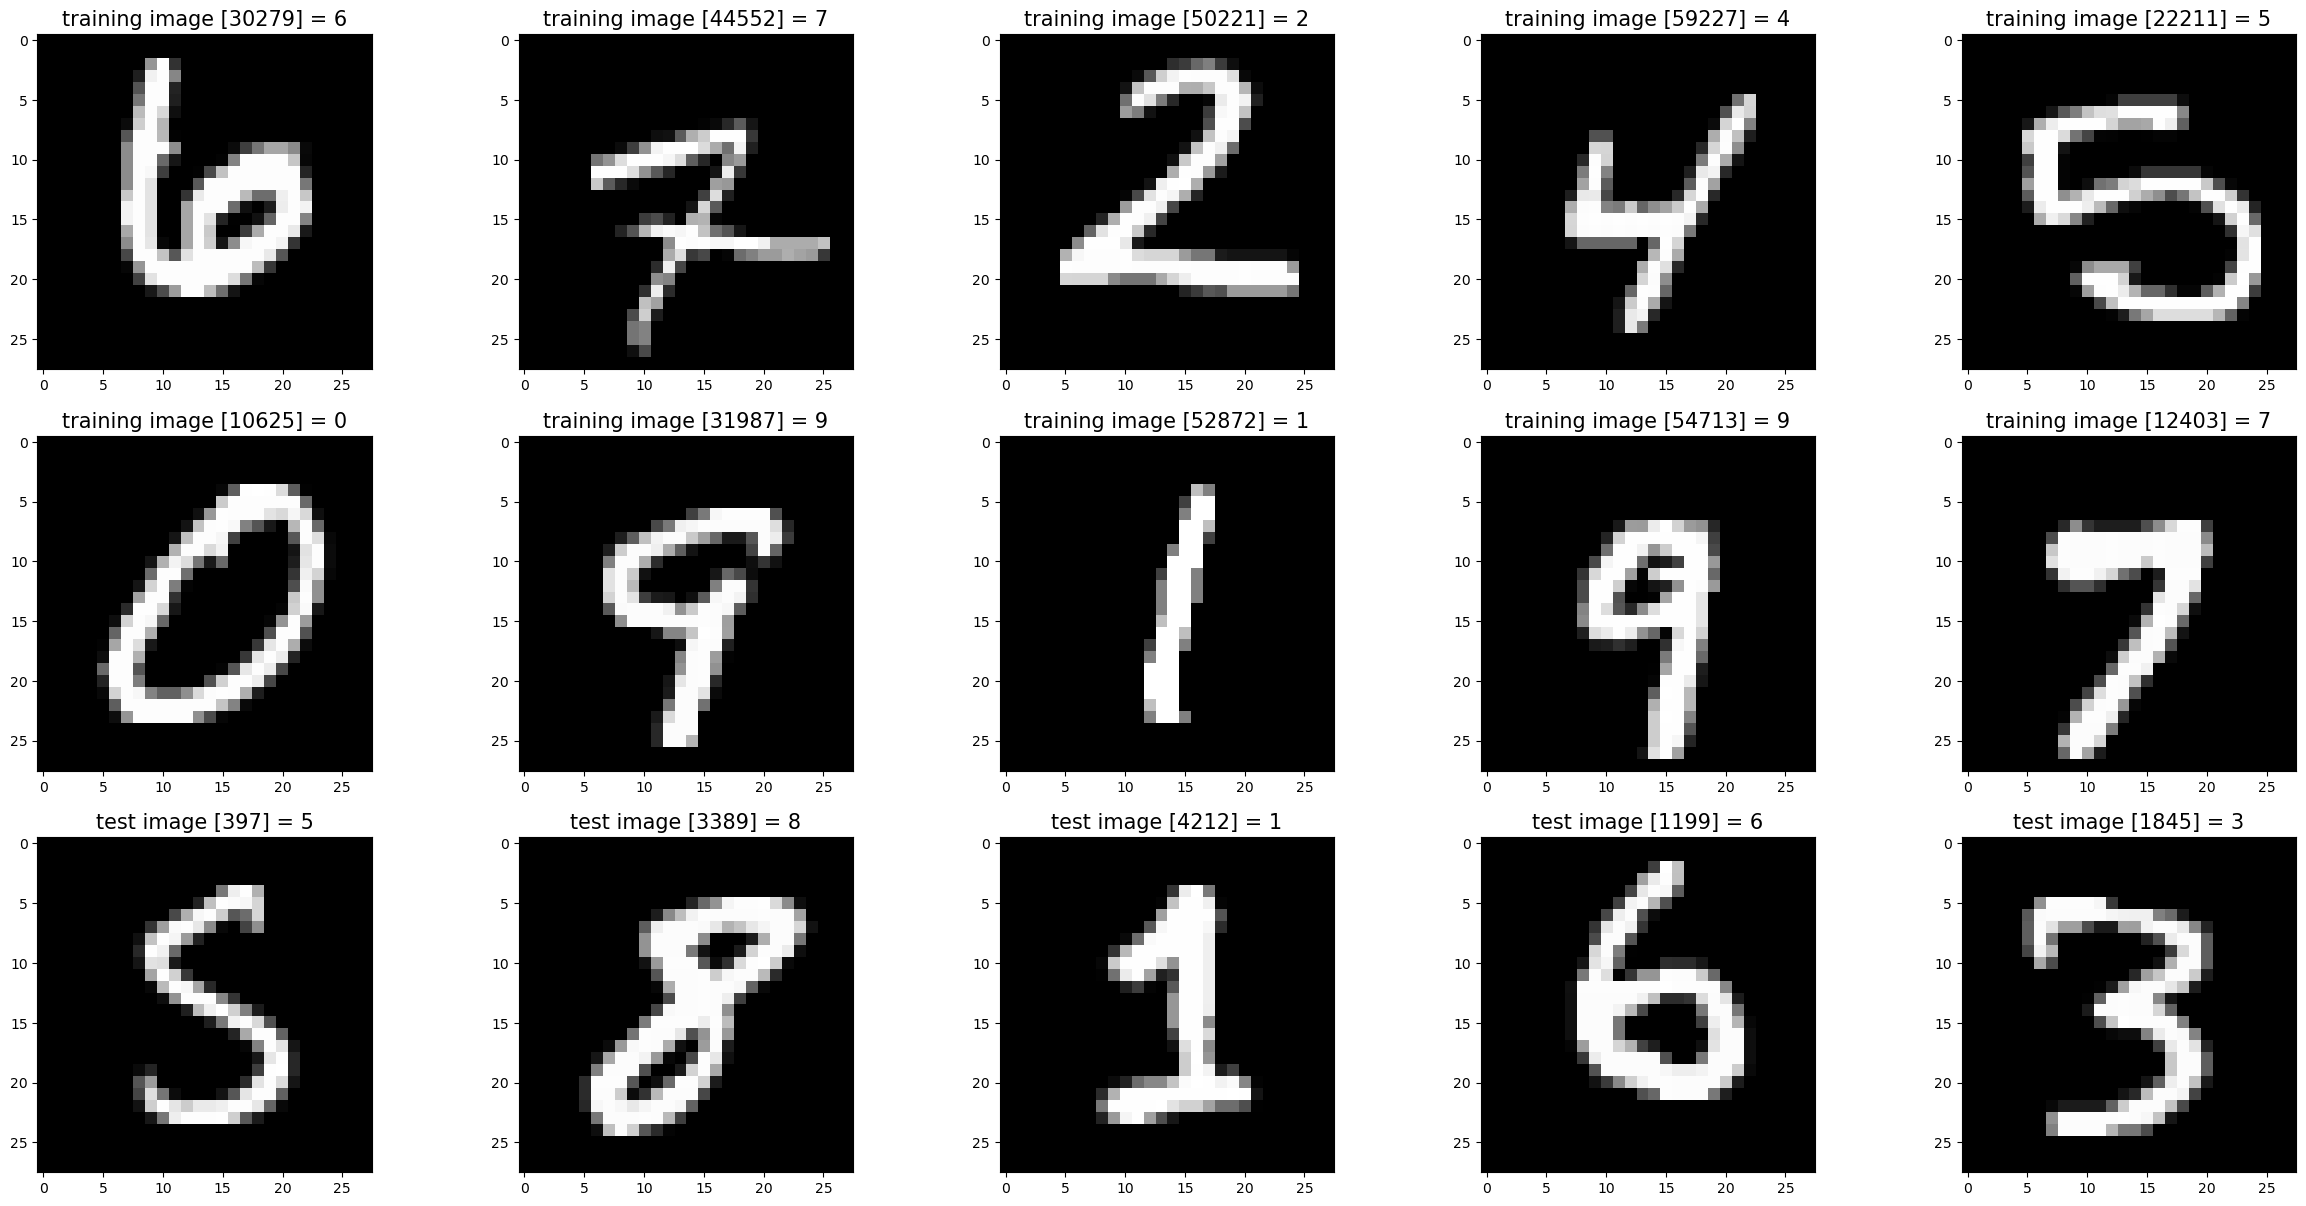

In [2]:
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = './'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# Load MINST dataset
 
# Implement your code to load: training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath
# OUR CODE
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


# Show some random training and test images 

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# OUR CODE
x_train, y_train = (np.array(x_train[0:5000]), np.array(y_train[0:5000]))
x_test, y_test = (np.array(x_test[0:5000]), np.array(y_test[0:5000]))

## Step 2: Preprocess the data

Identify the row and column indices of the pixels that have nonzero intensities in at least 600 of the training images. These will be the features used for classification. 

In [3]:
import numpy as np

# Assuming x_train is a list of 28x28 images (each image is a list or array of shape (28, 28))
num_imgs = len(x_train)
pixel_dimensions = (28, 28)  # Assuming MNIST size (28x28 images)

# Implement your code here
# OUR CODE
pixels_to_consider = []
for i in range(0, 600):
    indices = np.nonzero(x_train[i])
    pixels_to_consider.append(list(zip(indices[0], indices[1])))


num_features = len(pixels_to_consider)
# Outputs
print(f"Number of features (selected pixels): {num_features}")

Number of features (selected pixels): 600


In [4]:
min_occurrences = 600
pixel_counts = {}

for image in x_train:
    # Find which pixels are "on" in this image
    active_rows, active_cols = np.nonzero(image)
    active_pixels = list(zip(active_rows, active_cols))
    
    for pixel in active_pixels:
        if pixel not in pixel_counts:
            pixel_counts[pixel] = 1
        else:
            pixel_counts[pixel] += 1

# Keep pixels that showed up often enough
important_pixels = []
for pixel, count in pixel_counts.items():
    if count >= min_occurrences:
        important_pixels.append(pixel)

row_indices = np.array([pixel[0] for pixel in important_pixels])
col_indices = np.array([pixel[1] for pixel in important_pixels])
active_indices = np.array([row * 28 + col for row, col in important_pixels])

## Step 3: Create the least-squares classifier

Construct the matrix $A$ and vector $y$ as 
$$minimize \ \|A\theta - y\|_2 $$
Solve the least-square problem to obtain the parameter vector $\theta$. Create a plot showing the values of the entries of $\theta$ at different pixel locations.

In [5]:
def create_feature_matrix_and_labels(x_data, y_data, pixels_to_consider):
    num_imgs = len(x_data)
    x_data = np.array(x_data)
    x_data_flat = x_data.reshape(num_imgs, -1)
    
    # Create feature matrix A using only the active pixels
    A = x_data_flat[:, pixels_to_consider]
    
    # One-hot encoded labels
    y = np.zeros((num_imgs, 10))
    for i, label in enumerate(y_data):
        y[i, label] = 1
    
    return A, y

## Step 4: Implement the least-squares classifier

Load the first 5000 images of the test dataset. Using these images, compute the error rate, false positive rate, and false negative rate of your classifier.

In [6]:
from scipy.sparse.linalg import lsqr

A, y = create_feature_matrix_and_labels(x_train, y_train, active_indices)
print(f"Feature matrix shape: {A.shape}")
print(f"Labels matrix shape: {y.shape}")

# Solve least squares for each digit
theta = np.zeros((len(active_indices), 10))
for digit in range(10):
    result = lsqr(A, y[:, digit])
    theta[:, digit] = result[0]

Feature matrix shape: (5000, 329)
Labels matrix shape: (5000, 10)


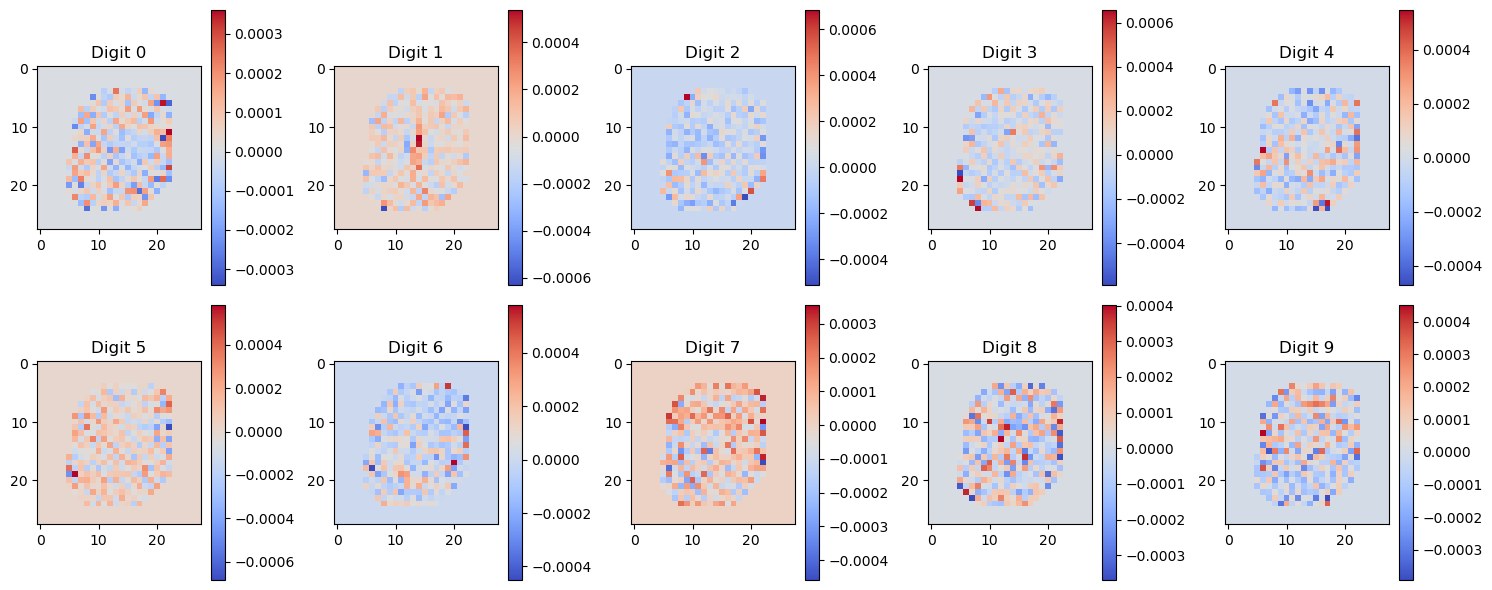

In [7]:
# Implement your code here to plot a heat map of the learned theta values
plt.figure(figsize=(15, 6))
for digit in range(10):
    plt.subplot(2, 5, digit + 1)
    theta_img = np.zeros((28, 28))
    for idx, (row, col) in enumerate(zip(row_indices, col_indices)):
        theta_img[row, col] = theta[idx, digit]
    plt.imshow(theta_img, cmap='coolwarm', interpolation='nearest')
    plt.title(f'Digit {digit}')
    plt.colorbar()
plt.tight_layout()
plt.show()

In [8]:
def test_theta_performance(x_test, y_test, active_indices, theta):
    num_test = len(x_test)
    x_test_flat = x_test.reshape(num_test, -1)

    # Make preds    
    test_features = x_test_flat[:, active_indices]
    predictions = np.dot(test_features, theta)
    predicted_digits = np.argmax(predictions, axis=1)
    true_digits = y_test  # assuming y_test has the actual digits (0-9)
    
    # Error rate
    num_wrong = np.sum(predicted_digits != true_digits)
    error_rate = num_wrong / len(y_test)
    
    # Calculate false positives and negatives for each digit
    fp_rates = []
    fn_rates = []
    
    for digit in range(10):
        should_be_digit = (true_digits == digit)
        predicted_as_digit = (predicted_digits == digit)
        
        false_positives = np.sum(predicted_as_digit & ~should_be_digit)
        false_negatives = np.sum(~predicted_as_digit & should_be_digit)
        
        total_negatives = np.sum(~should_be_digit)
        total_positives = np.sum(should_be_digit)
        
        fp_rate = false_positives / total_negatives if total_negatives > 0 else 0
        fn_rate = false_negatives / total_positives if total_positives > 0 else 0
        fp_rates.append(fp_rate)
        fn_rates.append(fn_rate)
    
    avg_fp_rate = np.mean(fp_rates)
    avg_fn_rate = np.mean(fn_rates)
    
    return error_rate, avg_fp_rate, avg_fn_rate

# Test it on first 5000 test images
x_test_subset = x_test[:5000]
y_test_subset = y_test[:5000]

error_rate, fp_rate, fn_rate = test_theta_performance(
    x_test_subset, 
    y_test_subset, 
    active_indices,  # Changed from pixels_to_consider to match the format
    theta
)

print(f"Results on {len(x_test_subset)} test images:")
print(f"Error rate: {error_rate:.3f}")
print(f"False positive rate: {fp_rate:.3f}")
print(f"False negative rate: {fn_rate:.3f}")

Results on 5000 test images:
Error rate: 0.225
False positive rate: 0.025
False negative rate: 0.228


## Step 5: Redo training with partial feature list

Repeat steps 1-4, except use only the first 100 images and labels of the training dataset to train the classifier. Use the same features that you identified in Step 2. How did the error rate and false positive/negative rates change?

In [ ]:
# Implement your code here

error_rate, false_positive_rate, false_negative_rate = test_theta_performance(x_test, y_test, pixels_to_consider, theta_less_data)
print(f"Performance of theta_less_data:")
print(f"Error rate: {error_rate}")
print(f"False positive rate: {false_positive_rate}")
print(f"False negative rate: {false_negative_rate}")

## Step 6: Feature Selection

In what follows, we will experiment with changing the feature set. Let $M_{0}$ denote the number of features that you identified in Step 2, and let $M = 5000$. Choose a matrix $R \in \mathbb{R}^{M \times M_{0}}$ whose entries are in $\{1, -1\}$ with equal probability. 
Letting $x_{i} \in \mathbb{R}^{M_{0}}$ denote the vector of features from Step 2 for the $i$-th image, the new feature vector is given by $\max{\{Rx_{i},0\}}$. Train a least-squares classifier using this new set of features.

In [ ]:
import numpy as np
from scipy.sparse.linalg import lsqr

def LS_classifier_artificial_features(M, R, x_train, y_train, pixels_to_consider, num_imgs):
    # implement your code here
    return theta


In [ ]:
# Implement your code to
# Set parameters
# Call the function to solve for theta
theta_arti_features = LS_classifier_artificial_features(M, R, x_train, y_train, pixels_to_consider, num_imgs)

# Output theta to verify
print(f"Solution theta shape: {theta.shape}")
print(f"First few theta values: {theta[:10]}")


## Step 7: Evaluate the new classifier

Compute the error rate, false positive rate, and false negative rate for the new classifier that you constructed in the previous step. Repeat the process with $M=20, 50, 1000, 5000, 10000$. 

In [ ]:
import numpy as np

# implement your code here to test the performance

